# Analysis 1: Corpus, Introduction, Data Collection

This notebook generates the Corpus image and the variables used in the Introduction and Data Collection Sections of the paper.

In [1]:
import sys
sys.path.insert(0, '../archaeology')

import re
import matplotlib

import numpy as np
import pandas as pd

from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import SVG

import analysis_helpers, importlib
importlib.reload(analysis_helpers)

from analysis_helpers import load_vars, var, relative_var
from analysis_helpers import savefig, display_counts, fig
from analysis_helpers import distribution_with_boxplot
from analysis_helpers import boxplot_distribution
from analysis_helpers import dbmt, DBMT, print_relative_var_group, dbmt_relative_var
from analysis_helpers import histogram, fig, boxplot_distribution, numpy_distribution
from db import connect

%matplotlib inline

## Query

- Select all notebooks
- Select all repositories

In [2]:
with connect() as session:
    print('Query Notebooks')
    boolagg = pd.read_sql("""
        SELECT n.id, n.id as notebook_id, n.repository_id, n.kernel, n.nbformat, n.language, n.processed,
        n.sha1_source, n.sha1_file, n.processing_cells, n.numeric_counts_total, n.numeric_set_total,
        n.max_execution_count, n.unambiguous, n.stargazers, n.forks, n.starforks, n.sfgroup,
        n.total_cells, n.code_cells, n.markdown_cells,
        m.invalid_format, n.skip, m.python_2, m.python_3, m.has_execution_count,
        m.topdown_attempted_execution, m.execorder_attempted_execution,
        m.topdown_run_all_cells, m.execorder_run_all_cells,
        m.topdown_image_same_results, m.execorder_image_same_results,
        m.topdown_execution_count_same_results, m.execorder_execution_count_same_results,
        m.topdown_original_same_results, m.execorder_original_same_results,
        m.has_assignment, m.has_course, m.has_exercise, m.has_homework, m.has_lesson,
        u.stargazers, u.forks, u.pushed_at, u.updated_at, u.history_commit_date
        FROM notebooks n 
        LEFT JOIN notebooks_bool_aggregates m ON (n.id = m.notebook_id)
        LEFT JOIN repository_updates u ON (n.repository_id = u.repository_id)
    """, session.connection())
    
    print('Query Repositories')
    t_repositories = pd.read_sql("""
        SELECT *
        FROM repositories
    """, session.connection())


Query Notebooks
Query Repositories


## Corpus

Calculate variables and generate corpus figure

In [3]:
print("Total repositories: {}".format(var("t_a1_repositories", len(t_repositories), "{:,}")))
print("Total notebooks: {}".format(var("t_a1_notebooks", t_repositories["notebooks_count"].sum(), "{:,}")))

Total repositories: 265,888
Total notebooks: 1,450,071


In [4]:
existing_notebooks = boolagg[
    (np.bitwise_and(boolagg["skip"], 2048) == 0)
]
existing_repositories = existing_notebooks.groupby("repository_id").size()
print("Existing notebooks: {}".format(var("u_a1_notebooks", len(existing_notebooks), "{:,}")))
print("Existing repositories: {}".format(var("u_a1_repositories", len(existing_repositories), "{:,}")))

Existing notebooks: 1,274,872
Existing repositories: 235,643


In [5]:
valid_notebooks = existing_notebooks[
    ~((existing_notebooks["kernel"] == "no-kernel") & (existing_notebooks["nbformat"] == "0"))
    & (np.bitwise_and(existing_notebooks["processed"], 15) == 0)
    & (np.bitwise_and(existing_notebooks["skip"], 1024 + 512) == 0)
]
valid_repositories = valid_notebooks.groupby("repository_id").size()
print("Valid notebooks: {}".format(var("f_a1_notebooks", len(valid_notebooks), "{:,}")))
print("Valid repositories: {}".format(var("f_a1_repositories", len(valid_repositories), "{:,}")))

Valid notebooks: 1,251,074
Valid repositories: 234,729


In [6]:
mask = valid_notebooks.duplicated(subset=['sha1_source'])

In [7]:
len(valid_notebooks[
    np.bitwise_and(valid_notebooks["skip"], 128) == 0
])

1024269

In [8]:
non_duplicated = valid_notebooks[
    np.bitwise_and(valid_notebooks["skip"], 1024 + 512 + 128) == 0
]
print("Non-duplicated notebooks: {}".format(var("d_a1_notebooks", len(non_duplicated), "{:,}")))

Non-duplicated notebooks: 1,024,269


In [9]:
print('Selection criteria:', var('b_a1_criteria', 'H.M.'))

Selection criteria: H.M.


In [10]:
bottom_notebooks = non_duplicated[
    non_duplicated['starforks'] == 0
]
print("Bottom notebooks: {}".format(relative_var(
    "b_a1_notebooks", len(bottom_notebooks), len(non_duplicated), "{:,}")
))

Bottom notebooks: 791,419 (77.27%)


In [11]:
vs = load_vars()
threshold = float(vs['s_a0_starforks'])

In [12]:
print('Popular criteria:', var('td_a1_criteria', '{:.3f}'.format(threshold)))

Popular criteria: 33.331


In [13]:
popular_notebooks = non_duplicated[
    non_duplicated['starforks'] > threshold
]
print("Popular notebooks: {}".format(relative_var(
    "td_a1_notebooks", len(popular_notebooks), len(non_duplicated), "{:,}")
))

Popular notebooks: 38,063 (3.72%)


In [14]:
non_duplicated_repos = non_duplicated.groupby("repository_id").count()
popular_repos = popular_notebooks.groupby("repository_id").count()
print("Popular repositories: {}".format(relative_var(
    "td_a1_repositories", len(popular_repos), len(non_duplicated_repos), "{:,}")
))

Popular repositories: 2,680 (1.18%)


In [15]:
samples = pd.read_excel("samples.xls")
sampled_notebooks = valid_notebooks[
    valid_notebooks["id"].isin(samples["notebook_id"])
]
print("Sample notebooks: {}".format(relative_var(
    "sd_a1_notebooks", len(sampled_notebooks), len(non_duplicated), "{:,}")
))

Sample notebooks: 69 (0.01%)


In [16]:
sampled_repos = sampled_notebooks.groupby("repository_id").count()
print("Sample repositories: {}".format(relative_var(
    "sd_a1_repositories", len(sampled_repos), len(non_duplicated_repos), "{:,}")
))

Sample repositories: 69 (0.03%)


In [17]:
python_notebooks = non_duplicated[
    non_duplicated["language"] == "python"
]

dbmt_relative_var(
    "Python notebooks: {}", 'a1_python_notebooks',
    dbmt(python_notebooks), dbmt(non_duplicated),
)


Python notebooks: a1_python_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"953,654 (93.11%)",None,None,None,None,None
1,(Sample),sd_,69 (100.00%),0.01%,0.01%,107.40%,(+) 7.40%,6.89%
2,(Popular),td_,"29,845 (78.41%)",3.13%,2.91%,84.22%,(-) 15.78%,-14.70%


In [18]:
r_notebooks = non_duplicated[
    non_duplicated["language"] == "R"
]
julia_notebooks = non_duplicated[
    non_duplicated["language"] == "julia"
]
unknown_notebooks = non_duplicated[
    non_duplicated["language"] == "unknown"
]
dbmt_relative_var(
    "R notebooks: {}", 'a1_r_notebooks',
    dbmt(r_notebooks), dbmt(non_duplicated), 
)
dbmt_relative_var(
    "Julia notebooks: {}", 'a1_julia_notebooks',
    dbmt(julia_notebooks), dbmt(non_duplicated), 
)
dbmt_relative_var(
    "Unknown language notebooks: {}", 'a1_unknown_notebooks',
    dbmt(unknown_notebooks), dbmt(non_duplicated),
)


R notebooks: a1_r_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"13,603 (1.33%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-1.33%
2,(Popular),td_,376 (0.99%),2.76%,0.04%,74.38%,(-) 25.62%,-0.34%


Julia notebooks: a1_julia_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"9,833 (0.96%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.96%
2,(Popular),td_,401 (1.05%),4.08%,0.04%,109.74%,(+) 9.74%,0.09%


Unknown language notebooks: a1_unknown_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"39,636 (3.87%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-3.87%
2,(Popular),td_,"7,158 (18.81%)",18.06%,0.70%,485.97%,(+) 385.97%,14.94%


In [19]:
python2_notebooks = python_notebooks[python_notebooks["python_2"]]
python3_notebooks = python_notebooks[python_notebooks["python_3"]]
python_unknown = python_notebooks[
    ~(
        python_notebooks["python_2"] 
        | python_notebooks["python_3"]
    )
]

dbmt_relative_var(
    "Python 2 notebooks: {}", 'a1_python2_notebooks',
    dbmt(python2_notebooks), dbmt(python_notebooks)
)
dbmt_relative_var(
    "Python 3 notebooks: {}", 'a1_python3_notebooks',
    dbmt(python3_notebooks), dbmt(python_notebooks)
)
dbmt_relative_var(
    "Unknown Python notebooks: {}", 'a1_python_unknown_notebooks',
    dbmt(python_unknown), dbmt(python_notebooks)
)

Python 2 notebooks: a1_python2_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"346,980 (36.38%)",None,None,None,None,None
1,(Sample),sd_,24 (34.78%),0.01%,0.00%,95.60%,(-) 4.40%,-1.60%
2,(Popular),td_,"11,467 (38.42%)",3.30%,1.20%,105.60%,(+) 5.60%,2.04%


Python 3 notebooks: a1_python3_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"605,872 (63.53%)",None,None,None,None,None
1,(Sample),sd_,45 (65.22%),0.01%,0.00%,102.65%,(+) 2.65%,1.69%
2,(Popular),td_,"18,332 (61.42%)",3.03%,1.92%,96.68%,(-) 3.32%,-2.11%


Unknown Python notebooks: a1_python_unknown_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,802 (0.08%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.08%
2,(Popular),td_,46 (0.15%),5.74%,0.00%,183.27%,(+) 83.27%,0.07%


In [20]:
valid_syntax = python_notebooks[
    (python_notebooks["python_2"] | python_notebooks["python_3"])
    & (np.bitwise_and(python_notebooks["processed"], 16) == 0)
]
dbmt_relative_var(
    "Python notebooks with valid syntax: {}", 'a1_valid_python_notebooks',
    dbmt(valid_syntax), dbmt(python_notebooks)
)

Python notebooks with valid syntax: a1_valid_python_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"886,668 (92.98%)",None,None,None,None,None
1,(Sample),sd_,65 (94.20%),0.01%,0.01%,101.32%,(+) 1.32%,1.23%
2,(Popular),td_,"28,145 (94.30%)",3.17%,2.95%,101.43%,(+) 1.43%,1.33%


In [21]:
executed_notebooks = non_duplicated[
    non_duplicated["has_execution_count"]
]
dbmt_relative_var(
    "Executed notebooks: {}", 'a1_executed_notebooks',
    dbmt(executed_notebooks), dbmt(non_duplicated),
)

Executed notebooks: a1_executed_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"932,382 (91.03%)",None,None,None,None,None
1,(Sample),sd_,64 (92.75%),0.01%,0.01%,101.89%,(+) 1.89%,1.72%
2,(Popular),td_,"32,821 (86.23%)",3.52%,3.20%,94.73%,(-) 5.27%,-4.80%


In [22]:
unambiguous_notebooks = executed_notebooks[
    (executed_notebooks["processing_cells"] == 0)
    & (executed_notebooks["unambiguous"] == 1)
]
dbmt_relative_var(
    "Unambiguous notebooks: {}", 'a1_unambiguous_notebooks',
    dbmt(unambiguous_notebooks), dbmt(executed_notebooks),
)

Unambiguous notebooks: a1_unambiguous_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"802,474 (86.07%)",None,None,None,None,None
1,(Sample),sd_,53 (82.81%),0.01%,0.01%,96.22%,(-) 3.78%,-3.25%
2,(Popular),td_,"28,059 (85.49%)",3.50%,3.01%,99.33%,(-) 0.67%,-0.58%


In [23]:
unambiguous_python_notebooks = unambiguous_notebooks[
    unambiguous_notebooks["python_2"] 
    | unambiguous_notebooks["python_3"] 
]
dbmt_relative_var(
    "Unambiguous Python notebooks: {}", 'a1_unambiguous_python_notebooks',
    dbmt(unambiguous_python_notebooks), dbmt(python_notebooks),
)

Unambiguous Python notebooks: a1_unambiguous_python_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"753,405 (79.00%)",None,None,None,None,None
1,(Sample),sd_,53 (76.81%),0.01%,0.01%,97.23%,(-) 2.77%,-2.19%
2,(Popular),td_,"22,332 (74.83%)",2.96%,2.34%,94.71%,(-) 5.29%,-4.18%


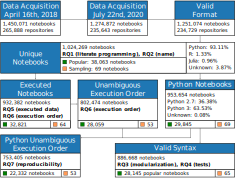

In [24]:
VAR = load_vars()

def replace(x):
    key = x.group(1)
    if key in VAR:
        return VAR[key].replace('\\textgreater{}', '>').replace("\\", "")
    print(key)
    return "\\u{{{}}}".format(key)

with open("corpus_template.svg", "r") as f:
    svg_content = f.read()
with open("outputs/a1_corpus.svg", "w") as f:
    f.write(re.sub(r"\\v\{(.*?)\}", replace, svg_content))
SVG("outputs/a1_corpus.svg")

In [25]:
!inkscape outputs/a1_corpus.svg --export-pdf=outputs/a1_corpus.pdf

## Introduction

Additional variables used in the introduction

In [26]:
attempted_execution = unambiguous_python_notebooks[
    unambiguous_python_notebooks["topdown_attempted_execution"]
    | unambiguous_python_notebooks["execorder_attempted_execution"]
]
dbmt_relative_var(
    "Attempted executions: {}", 'a1_attempted_executions',
    dbmt(attempted_execution), dbmt(unambiguous_python_notebooks),
)

Attempted executions: a1_attempted_executions


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"672,146 (89.21%)",None,None,None,None,None
1,(Sample),sd_,43 (81.13%),0.01%,0.01%,90.94%,(-) 9.06%,-8.08%
2,(Popular),td_,"17,411 (77.96%)",2.59%,2.31%,87.39%,(-) 12.61%,-11.25%


In [27]:
repro_finished = attempted_execution[
    attempted_execution["topdown_run_all_cells"]
    | attempted_execution["execorder_run_all_cells"]
]
dbmt_relative_var(
    "Run all cells: {}", 'a1_repro_finished',
    dbmt(repro_finished), dbmt(attempted_execution),
)

Run all cells: a1_repro_finished


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"162,977 (24.25%)",None,None,None,None,None
1,(Sample),sd_,13 (30.23%),0.01%,0.00%,124.68%,(+) 24.68%,5.99%
2,(Popular),td_,"5,532 (31.77%)",3.39%,0.82%,131.04%,(+) 31.04%,7.53%


In [28]:
same_results_original = attempted_execution[
    attempted_execution["topdown_original_same_results"]
    | attempted_execution["execorder_original_same_results"]
]
dbmt_relative_var(
    "Same results (original): {}", 'a1_same_results_original',
    dbmt(same_results_original), dbmt(attempted_execution),
)

Same results (original): a1_same_results_original


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"37,595 (5.59%)",None,None,None,None,None
1,(Sample),sd_,5 (11.63%),0.01%,0.00%,207.89%,(+) 107.89%,6.03%
2,(Popular),td_,"1,800 (10.34%)",4.79%,0.27%,184.83%,(+) 84.83%,4.75%


In [29]:
same_results_image = attempted_execution[
    attempted_execution["topdown_image_same_results"]
    | attempted_execution["execorder_image_same_results"]
]
dbmt_relative_var(
    "Same results (image): {}", 'a1_same_results_image',
    dbmt(same_results_image), dbmt(attempted_execution),
)

Same results (image): a1_same_results_image


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"84,669 (12.60%)",None,None,None,None,None
1,(Sample),sd_,7 (16.28%),0.01%,0.00%,129.23%,(+) 29.23%,3.68%
2,(Popular),td_,"3,100 (17.80%)",3.66%,0.46%,141.34%,(+) 41.34%,5.21%


## Data Collection

Additional variables used in the data collection

### Notebooks count by repository

In [30]:
repositories_2_or_fewer = t_repositories[
    t_repositories["notebooks_count"] <= 2
]

print("Repositories with 2 or fewer notebooks: {}".format(relative_var(
    "t_a1_repositories_2_notebooks", len(repositories_2_or_fewer), len(t_repositories), "{:,}")
))

Repositories with 2 or fewer notebooks: 159,764 (60.09%)


In [31]:
repositories_10_or_more = t_repositories[
    t_repositories["notebooks_count"] >= 10
]

print("Repositories with 10 or more notebooks: {}".format(relative_var(
    "t_a1_repositories_10_or_more", len(repositories_10_or_more), len(t_repositories), "{:,}")
))

Repositories with 10 or more notebooks: 33,027 (12.42%)


In [32]:
print("Notebooks from repositories with 10 or more notebooks: {}".format(relative_var(
    "t_a1_notebooks_from_repositories_with_10_or_more",
    repositories_10_or_more["notebooks_count"].sum(),
    t_repositories["notebooks_count"].sum(), "{:,}")
))

Notebooks from repositories with 10 or more notebooks: 891,034 (61.45%)


### Duplicated notebooks

In [33]:
duplicated_total = len(valid_notebooks) - len(non_duplicated)
print("Duplicated notebooks: {}".format(relative_var(
    "f_a1_removed_duplicated_notebooks",
    duplicated_total,
    len(valid_notebooks)
)))

Duplicated notebooks: 226,805 (18.13%)


### Programming language

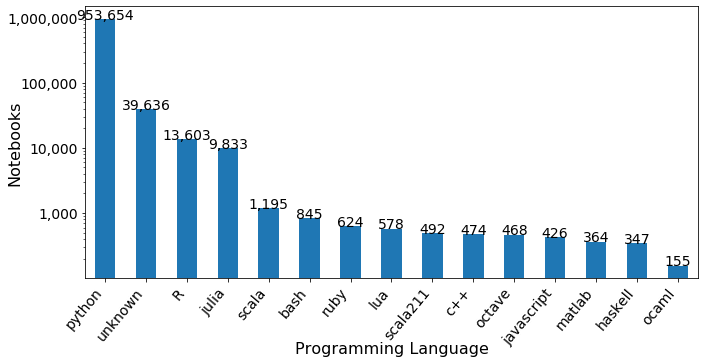

(Sample) 


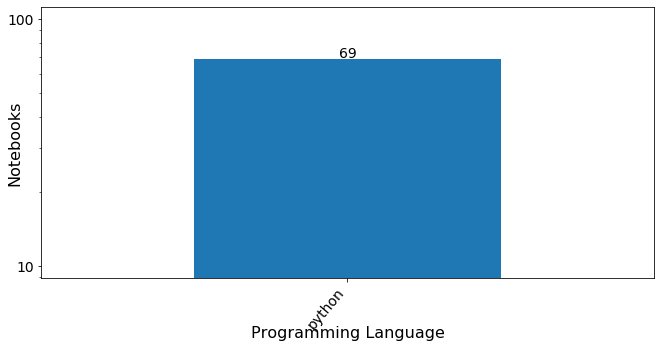

(Popular) 


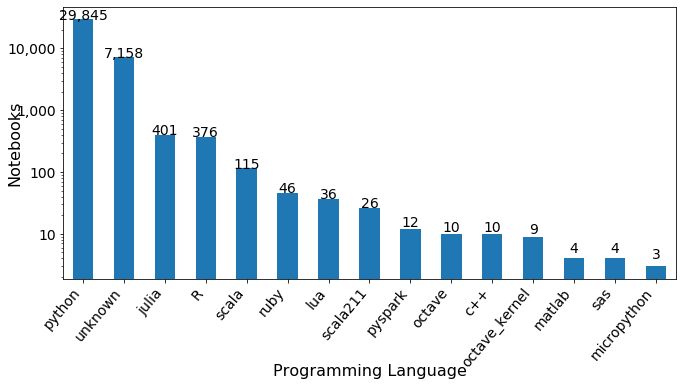

In [34]:
def programming_language(counts, prefix):
    with savefig(prefix + "a1_programming_language", 11, 5):
        fig, cnt = display_counts(counts, show_values=True, plot=False, template="{:,.0f}", template2="{:,.0f}", cut=slice(None, 15))
        ax = plt.gca()
        ax.set_ylabel("Notebooks")
        ax.set_xlabel("Programming Language")
        ax.legend().set_visible(False)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
        ax.xaxis.labelpad = -6
        ax.yaxis.labelpad = -15

dfs = dbmt(non_duplicated)
for df, (prefix, name) in zip(dfs, DBMT):
    print(name)
    programming_language(df["language"].value_counts(), prefix)
    plt.show()


### Notebooks with nbformat <= 3 are probably Python
But they do not declare python version

In [35]:
dbmt_relative_var(
    "Notebooks with nbformat <= 3: {}", "a1_nbformat_lt_3",
    dbmt(non_duplicated[non_duplicated.nbformat.astype(float) <= 3]),
    dbmt(non_duplicated),
)

Notebooks with nbformat <= 3: a1_nbformat_lt_3


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"30,953 (3.02%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-3.02%
2,(Popular),td_,"6,602 (17.34%)",21.33%,0.64%,573.96%,(+) 473.96%,14.32%


### Max execution count

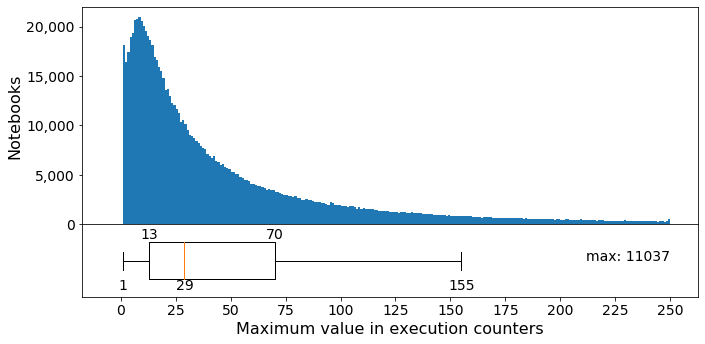

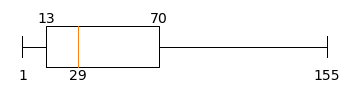

(Sample) 


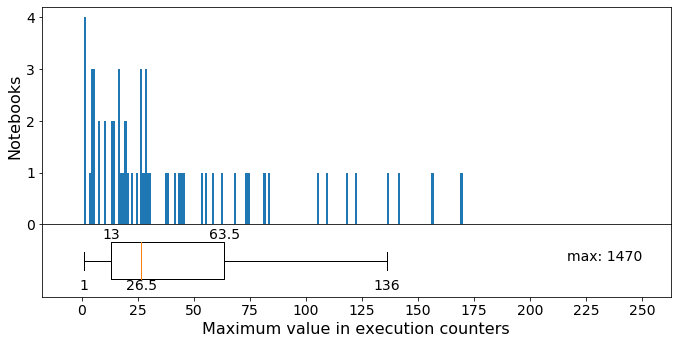

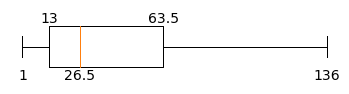

(Popular) 


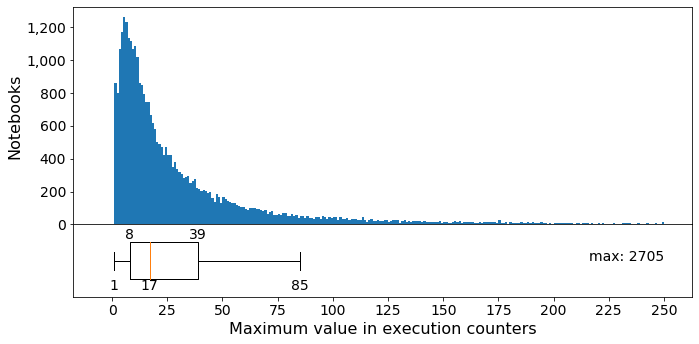

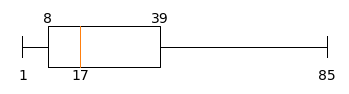

In [36]:
column = executed_notebooks["max_execution_count"]
def max_exectuion_count(column, prefix):
    with savefig(prefix + "a1_max_execution_count_full", 9, 5):
        distribution = distribution_with_boxplot(column, -5, 250, 25, "Notebooks", "Maximum value in execution counters",  True)
    gcf = plt.gcf()
    display(gcf)
    plt.close(gcf)
    with savefig(prefix + "a1_max_execution_count", 5, 1.25):
        boxplot_distribution(column, -5, 250, 25, "Notebooks", "Maximum value in execution counters",  True)

dfs = dbmt(executed_notebooks)
for df, (prefix, name) in zip(dfs, DBMT):
    print(name)
    max_exectuion_count(df["max_execution_count"], prefix)
    gcf = plt.gcf()
    display(gcf)
    plt.close(gcf)



Execution Count Dist Distribution(min=1, q1=13.0, median=29.0, q3=70.0, max=11037)
Execution Count Median 29
Execution Count Max 11,037
Code Cells Dist Distribution(min=1, q1=8.0, median=14.0, q3=25.0, max=797)
Code Cells Median 14
Code Cells Max 797


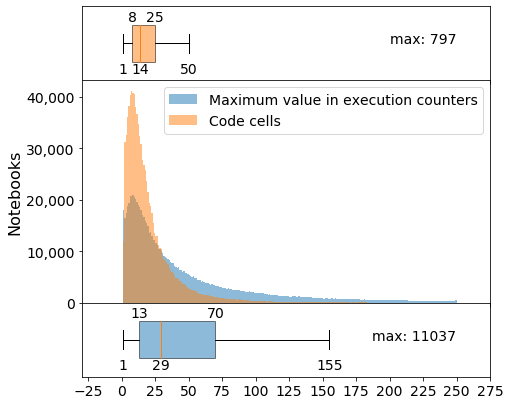

(Sample) 
Execution Count Dist Distribution(min=1, q1=13.0, median=26.5, q3=63.5, max=1470)
Execution Count Median 26.5
Execution Count Max 1,470
Code Cells Dist Distribution(min=1, q1=7.0, median=18.5, q3=27.25, max=292)
Code Cells Median 18.5
Code Cells Max 292


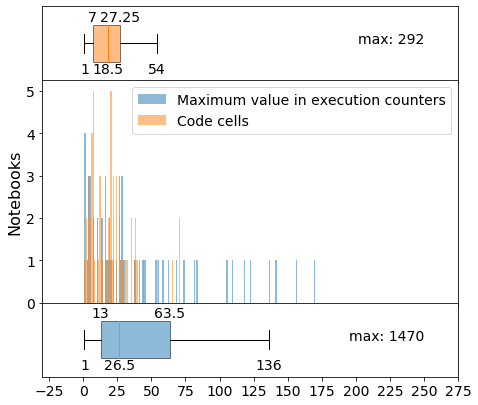

(Popular) 
Execution Count Dist Distribution(min=1, q1=8.0, median=17.0, q3=39.0, max=2705)
Execution Count Median 17
Execution Count Max 2,705
Code Cells Dist Distribution(min=1, q1=6.0, median=11.0, q3=21.0, max=602)
Code Cells Median 11
Code Cells Max 602


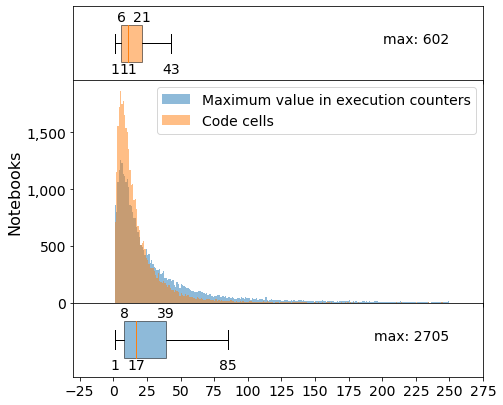

In [37]:
def code_cells_max_exectuion_count(df, prefix):
    column = df["max_execution_count"]
    with savefig(prefix + "a1_code_cells_max_execution_count", 6, 6):
        gcf, (ax3, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw = {'height_ratios':[1, 3, 1]})
        first, last, step = -5, 250, 25
        bins = last - first
        histogram(df["max_execution_count"].values, bins, step, (first, last), ax=ax1, alpha=0.5)
        histogram(df["code_cells"].values, bins, step, (first, last), ax=ax1, alpha=0.5)
        boxplot_distribution(df["max_execution_count"], first, last, step, "Notebooks", "Maximum value in execution counters", True, ax=ax2, color="tab:blue", alpha=0.5, show_list=True)
        boxplot_distribution(df["code_cells"], first, last, step, "Notebooks", "Code cells", True, ax=ax3, color="tab:orange", alpha=0.5, show_list=True)
        
        ax1.xaxis.tick_bottom()
        ax1.set_ylabel("Notebooks")
        ax1.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: "{0:,g}".format(x)))
        ax2.yaxis.set_ticks_position('none')
        ax2.set_yticklabels([""])
        ax2.set_xlabel("")
        ax2.axis("on")
        ax3.set_xlabel("Code cells")
        ax3.axis("on")
        plt.tight_layout()
        plt.subplots_adjust(hspace=0)
        
        ax1.legend(["Maximum value in execution counters", "Code cells"])
        
        max_execution_count_dist = numpy_distribution(df["max_execution_count"])
        print("Execution Count Dist", max_execution_count_dist)
        print("Execution Count Median", var(prefix + "a1_max_execution_count_median", max_execution_count_dist.median, "{:g}"))
        print("Execution Count Max", var(prefix + "a1_max_execution_count_max", max_execution_count_dist.max, "{:,g}"))
        
        code_cells_dist = numpy_distribution(df["code_cells"])
        print("Code Cells Dist", code_cells_dist)
        print("Code Cells Median", var(prefix + "a1_code_cells_in_executed_median", code_cells_dist.median, "{:g}"))
        print("Code Cells Max", var(prefix + "a1_code_cells_in_executed_max", code_cells_dist.max, "{:,g}"))
        
        

dfs = dbmt(executed_notebooks)
for df, (prefix, name) in zip(dfs, DBMT):
    print(name)
    code_cells_max_exectuion_count(df, prefix)
    gcf = plt.gcf()
    display(gcf)
    plt.close(gcf)


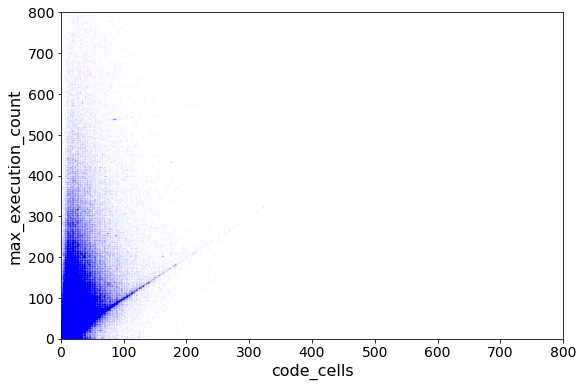

(Sample) 


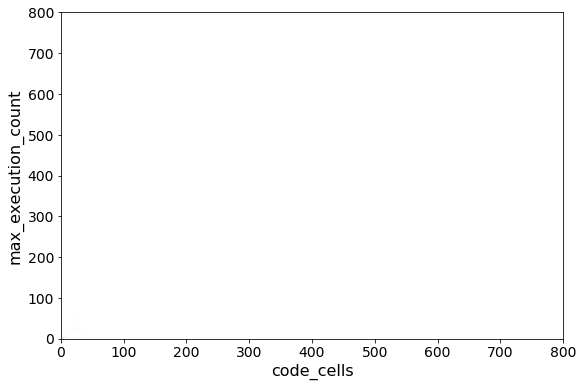

(Popular) 


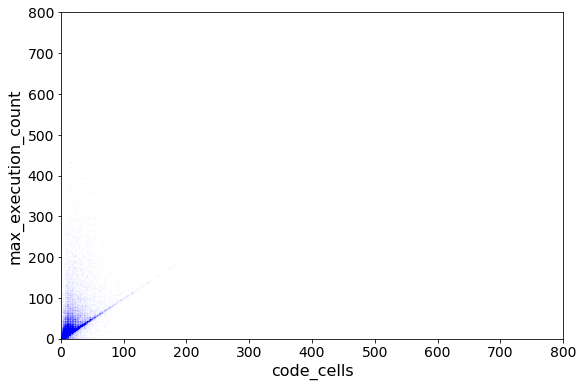

In [38]:
def correrlation(df, prefix):
    column = df["max_execution_count"]
    with fig(prefix + "a1_correlation_alpha", 9, 6):
        df.plot.scatter(x="code_cells", y="max_execution_count", alpha=0.01, c='b', s=1)
        ax = plt.gca()
        ax.set_xlim([0, 800])
        ax.set_ylim([0, 800])


dfs = dbmt(executed_notebooks)
for df, (prefix, name) in zip(dfs, DBMT):
    print(name)
    correrlation(df, prefix)
    gcf = plt.gcf()
    display(gcf)
    plt.close(gcf)
    


## Toy

In [39]:
dbmt_relative_var(
    "Possible toy notebooks: {}", "a1_toy",
    dbmt(non_duplicated[
        non_duplicated["has_assignment"] 
        | non_duplicated["has_course"]
        | non_duplicated["has_exercise"]
        | non_duplicated["has_homework"]
        | non_duplicated["has_lesson"]
    ]), 
    dbmt(non_duplicated),
)

Possible toy notebooks: a1_toy


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"164,463 (16.06%)",None,None,None,None,None
1,(Sample),sd_,16 (23.19%),0.01%,0.00%,144.42%,(+) 44.42%,7.13%
2,(Popular),td_,"6,959 (18.28%)",4.23%,0.68%,113.86%,(+) 13.86%,2.23%


## Maintanability

In [40]:
six_months_after_notebooks = valid_notebooks[valid_notebooks["pushed_at"] > valid_notebooks["history_commit_date"] + pd.Timedelta(weeks=26)]
print("Repositories that were active 6 months after the collected commit:", relative_var(
    "f_a1_active_six_months", 
    len(six_months_after_notebooks.groupby("repository_id").count()),
     len(valid_notebooks.groupby("repository_id").count()),
))

Repositories that were active 6 months after the collected commit: 29,768 (12.68%)


In [41]:
requery_date = datetime(2020, 7, 22)
last_six_months_notebooks = valid_notebooks[valid_notebooks["pushed_at"] > requery_date - pd.Timedelta(weeks=26)]
print("Repositories that were active in the last 6 months:", relative_var(
    "f_a1_updated_six_months", 
    len(last_six_months_notebooks.groupby("repository_id").count()),
     len(valid_notebooks.groupby("repository_id").count()),
))

Repositories that were active in the last 6 months: 6,673 (2.84%)


This notebook calculated all the paper variables that are used in the Introduction and Data collection sections of the Paper. For other analysis referring to each specific subset of the notebooks, refer to the other notebooks.